<a href="https://colab.research.google.com/github/DimitrisTzivrailis/RBM/blob/master/phi4sampling_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import csv
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from numba import njit
from tqdm import tqdm
import os
from datetime import datetime

# Analytical Metropolis Hastings Algorithm

In [ ]:
@njit(nogil=True)
def deltaS_elastic(phi, i, j, L, delta):
  force = -4*phi[i,j]+phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]
  dS = (2*delta-force)*delta  # dont forget that this is 2 dimesional
  return dS

@njit(nogil=True)
def deltaS_potential(phi, i, j, L, delta, lmb, mu):
  dS_quadratic = delta*lmb*(phi[i,j]+delta/2)
  dS_quartic = (mu/4)*((phi[i,j]+delta)**4-phi[i,j]**4)
  return dS_quadratic+dS_quartic

@njit(nogil=True)
def metropolis_hastings_analytical(phi,L,lmd,mu):
  for i, j,delta in zip(np.random.randint(0,L,size=L*L), np.random.randint(0,L, size=L*L), np.random.normal(0,1,size=L*L)):
      dS = deltaS_elastic(phi, i, j, L, delta)+deltaS_potential(phi, i, j, L, delta, lmd, mu)
      p = min(1, np.exp(-dS))
      if(np.random.rand()<p):
        phi[i,j] += delta

# Computation of Action of the form $-\phi_{i,j} (n.n) + (2+\frac{\mu}{2})\phi_{i,j}^2 + \frac{\lambda}{4!}\phi_{i,j}^4$

In [ ]:
@njit(nogil=True)
def action(phi,L,mu,lmd):
  S_total = 0
  for i in range(L):
    for j in range(L):
        S = -phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + (2+mu/2)*phi[i,j]**2 +lmd/(4*3*2) * phi[i,j]**4
        S_total += S
  return S_total

# Computation of Action with form $-\beta \phi_{i,j} (n.n) +\phi_{i,j}^2 + \lambda (\phi_{i,j}^2 -1)^2$

In [ ]:
@njit(nogil=True)
def action2(phi,L,mu,lmd):
  S_total = 0
  for i in range(L):
    for j in range(L):
        S = -mu * phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + phi[i,j]**2 +lmd*( phi[i,j]**2 -1)**2
        S_total += S
  return S_total

In [ ]:
@njit(nogil=True)
def metropolis_hastings(phi,L,mu,lmd):
  A = 0
  for i, j,delta in zip(np.random.randint(0,L,size=L*L), np.random.randint(0,L, size=L*L), np.random.normal(0,1,size=L*L)):

      S_old = action2(phi,L,mu,lmd)
      phi[i,j] = phi[i,j] + 0.1*delta
      S_new = action2(phi,L,mu,lmd)

      dS = S_new - S_old

      p = min(1, np.exp(-dS))
      if(np.random.rand()<p):
        A += 1
      else:
        phi[i,j] = phi[i,j] - delta

  return A/L**2

# Local Metropolis Hastings algorithm

In [ ]:
@njit(nogil=True)
def metropolis_hastings_local(phi,L,mu,lmd):
  A = 0
  for i, j,delta in zip(np.random.randint(0,L,size=L*L), np.random.randint(0,L, size=L*L), np.random.normal(0,1,size=L*L)):

      #S_old = -mu* phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + phi[i,j]**2 +lmd * (phi[i,j]**2 -1)**2
      S_old = -phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + (2+mu/2)*phi[i,j]**2 +lmd/(4*3*2) * phi[i,j]**4
      phi[i,j] = phi[i,j] + delta
      #S_new = -mu*phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + phi[i,j]**2 +lmd * (phi[i,j]**2 -1)**2
      S_new =  -phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + (2+mu/2)*phi[i,j]**2 +lmd/(4*3*2) * phi[i,j]**4

      dS = S_new - S_old

      p = min(1, np.exp(-dS))
      if(np.random.rand()<p):
        A += 1
      else:
        phi[i,j] = phi[i,j] - delta

  return A/L**2

# Tests for the dS from the Metropolis Hastings

In [ ]:
def super_hybrid_mc_algorithm(phi,L,mu,lmd):
  for i, j,delta in zip(np.random.randint(0,L,size=L*L), np.random.randint(0,L, size=L*L), np.random.normal(0,1,size=L*L)):

    S_old_local = -mu* phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + phi[i,j]**2 +lmd * (phi[i,j]**2 -1)**2
    S_old_total = action2(phi,L,mu,lmd)
    phi[i,j] = phi[i,j] + 0.1*delta
    S_new_local = -mu*phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + phi[i,j]**2 +lmd * (phi[i,j]**2 -1)**2
    S_new_total = action2(phi,L,mu,lmd)
    dS_local = S_new_local - S_old_local
    dS_total = S_new_total - S_old_total

    p = min(1, np.exp(-dS_total))
    if(np.random.rand()<p):
      phi[i,j] = phi[i,j]
    else:
      phi[i,j] = phi[i,j] - delta
  return dS_local, dS_total

In [ ]:
def super_hybrid_mc_algorithm2(phi,L,mu,lmd):
  for i, j,delta in zip(np.random.randint(0,L,size=L*L), np.random.randint(0,L, size=L*L), np.random.normal(0,1,size=L*L)):

    dS_analytical = deltaS_elastic(phi, i, j, L, delta)+deltaS_potential(phi, i, j, L, 0.01*delta, lmd, mu)

    S_old_local = - phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + (2+mu/2)*phi[i,j]**2 +(lmd/4) * phi[i,j]**4
    phi[i,j] = phi[i,j] + delta
    S_new_local = -phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + (2+mu/2)*phi[i,j]**2 +lmd/4 * phi[i,j]**4



    dS_local = S_new_local - S_old_local

    p = min(1, np.exp(-dS_local))
    if(np.random.rand()<p):
      phi[i,j] = phi[i,j]
    else:
      phi[i,j] = phi[i,j] - delta
  return dS_local, dS_analytical

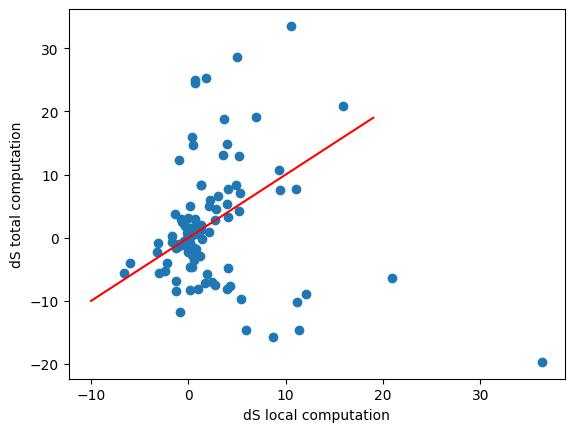

In [ ]:
L = 2
lmd = 0.01
mu = -1
steps = 100
lattice = np.random.normal(0,1,(L,L))
dS_local = []
dS_analytical = []
for i in range(steps):
  a,b = super_hybrid_mc_algorithm2(lattice,L,mu,lmd)
  dS_local.append(a)
  dS_analytical.append(b)

def linear_function(x):
  return x
x = [i-10 for i in range(30)]
plt.figure()
plt.scatter(dS_local,dS_analytical)
plt.xlabel("dS local computation")
plt.ylabel("dS total computation")
plt.plot(x,linear_function(x),c='r')
plt.show()

# Illustation of the field

0.4375


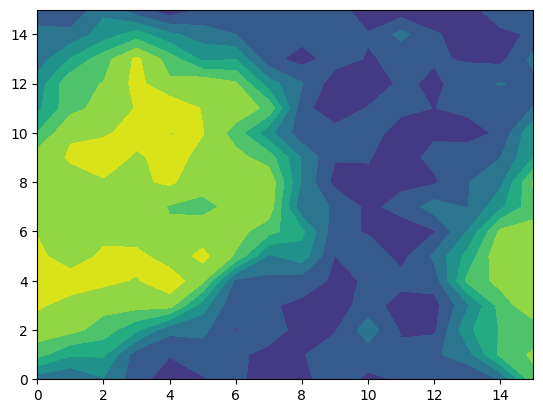

In [ ]:
L = 16
lmd = 0.1
mu = 1
steps = 100
lattice = np.random.normal(0,1,(L,L))
for i in range(steps):
  acc = metropolis_hastings_local(lattice,L,mu,lmd)

print(acc)
plt.contourf(lattice)

# Computation of the total Action with the formula $-\phi_{i,j} (n.n) + (2+\frac{\mu}{2})\phi_{i,j}^2 + \frac{\lambda}{4!}\phi_{i,j}^4$

In [ ]:
def total_action(data,L,mu,lmd,number_of_samples):
    collection_of_energies = np.zeros(number_of_samples)
    for k in range(number_of_samples):
      S_total = 0
      for i in range(L):
        for j in range(L):
          config = data[k].reshape(L,L)
          S = -config[i,j]*(config[(i+1)%L,j]+config[(i-1)%L,j]+config[i, (j+1)%L]+config[i, (j-1)%L]) + (2+mu/2)*config[i,j]**2 +lmd/(4*3*2) * config[i,j]**4
          S_total += S
      collection_of_energies[k] = S_total

    return collection_of_energies

# Computation of the total action with formula $-\beta \phi_{i,j} (n.n) +\phi_{i,j}^2 + \lambda (\phi_{i,j}^2 -1)^2$

In [ ]:
def total_action2(data,L,mu,lmd,number_of_samples):
    collection_of_energies = np.zeros(number_of_samples)
    for k in range(number_of_samples):
      S_total = 0
      for i in range(L):
        for j in range(L):
          config = data[k].reshape(L,L)
          S = -mu*config[i,j]*(config[(i+1)%L,j]+config[(i-1)%L,j]+config[i, (j+1)%L]+config[i, (j-1)%L]) + config[i,j]**2 +lmd * (config[i,j]**2 -1)**2
          S_total += S
      collection_of_energies[k] = S_total

    return collection_of_energies

# Sample generator

In [ ]:
def generate(phi,L,mu,lmd,equilibrium,number_of_samples):
      samples = []
      for i in range(equilibrium+number_of_samples):
        metropolis_hastings_local(phi,L,mu,lmd) # choose algorithm for gneration
        if i >= equilibrium:
          samples.append(phi.flatten())
      return samples

# Constuction of samples for every possible range

In [ ]:
def distributions_of_data(phi,L,mu,lmd,equilibrium,number_of_samples):
  positive = []
  negative = []
  num = 0
  while num != 2:
    phi = np.random.normal(0,1,(L,L))
    samples = generate(phi,L,mu,lmd,equilibrium,number_of_samples)
    flattened_list_samples = [item for sublist in samples for item in sublist]
    check = np.mean(flattened_list_samples)
    if check > 0 and len(positive) == 0:
      positive.append(samples)
      actions_1 = total_action(samples,L,mu,lmd,number_of_samples) # choose total action formula
    elif check < 0 and len(negative) ==0:
      negative.append(samples)
      actions_2 = total_action(samples,L,mu,lmd,number_of_samples)
    num = len(positive) + len(negative)

  return np.concatenate((positive[0],negative[0]),axis=0), np.concatenate((actions_1,actions_2),axis=0)

In [ ]:
L = 2
mu = -1
lmd = 1
number_of_samples = 2500
equilibrium = 100
lattice = np.random.normal(0,1,(L,L))
#lattice = np.zeros((L,L))
samples,actions  = distributions_of_data(lattice,L,mu,lmd,equilibrium,number_of_samples)

# Distribution of the Samples

0.008270608609061583


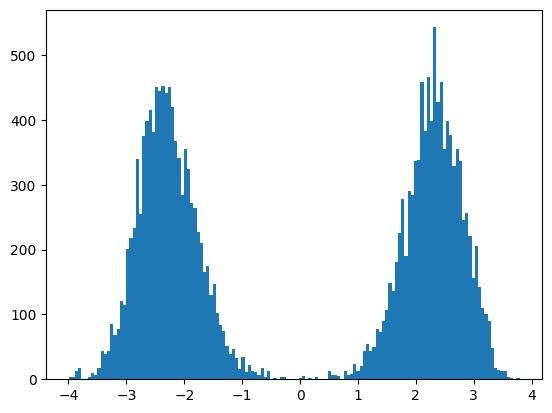

In [ ]:
plt.figure()
flattened_list_samples = [item for sublist in samples for item in sublist]
num_bins = int(np.sqrt(len(flattened_list_samples)))
plt.hist(flattened_list_samples, bins=num_bins)
print(np.mean(np.array(flattened_list_samples)))
plt.show()

# Distribution of the Actions of the samples

-47.01511567984458


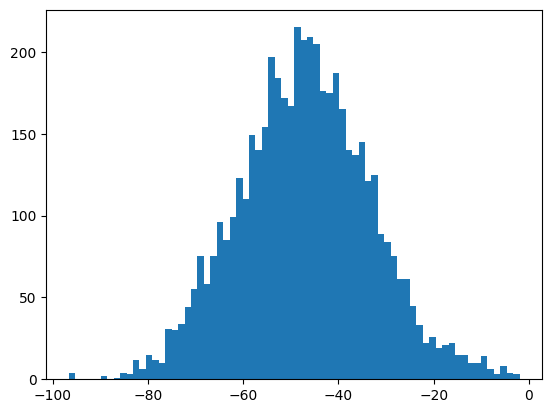

In [ ]:
plt.figure()
num_bins = int(np.sqrt(len(actions)))
plt.hist(actions, bins=num_bins)
print(np.mean(np.array(actions)))
plt.show()

# Transformation of data in pytorch tensors

In [ ]:
x = torch.tensor(np.array(samples)).to(torch.float32)
y = (torch.tensor(actions).to(torch.float32)).unsqueeze(dim=1)

In [ ]:
from numpy.random.mtrand import random_integers
# split data into training and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=42)

In [ ]:
input_size = 4
hidden_size_1 = 512
#hidden_size_2 =24
output_size = 1

model = nn.Sequential(nn.Linear(input_size, hidden_size_1)
                      ,nn.Tanh()
                      ,nn.Linear(hidden_size_1,output_size)
                      ,nn.Tanhshrink()
                      )
print(model)

Sequential(
  (0): Linear(in_features=4, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=1, bias=True)
  (3): Tanhshrink()
)


# Model architecture of the local metropolis hastings

In [ ]:
input_size = 4
hidden_size_1 = 128 # or 256
#hidden_size_2 =24
output_size = 1

model = nn.Sequential(nn.Linear(input_size, hidden_size_1)
                      ,nn.Tanh()
                      ,nn.Linear(hidden_size_1,output_size)
                      ,nn.Tanhshrink()
                      )
print(model)

Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): Tanh()
  (2): Linear(in_features=128, out_features=1, bias=True)
  (3): Tanhshrink()
)


In [ ]:
criterion = nn.MSELoss()
configs = x_train
energies = y_train
configurations = model(configs)
loss = criterion(configurations, energies)

# Training of the neural network

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs =10000
train_loss_function = []
test_loss_function = []
steps = []
i = 0
for epoch in range(num_epochs):
    model.train()

    optimizer.zero_grad()

    outputs = model(x_train)

    loss = criterion(outputs, y_train)

    loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
      test_pred = model(x_test)

      test_loss = criterion(test_pred,y_test)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        train_loss_function.append(loss.item())
        test_loss_function.append(test_loss)
        steps.append(i)
        i += 1

Epoch [100/10000], Loss: 2154.5879
Epoch [200/10000], Loss: 1684.5844
Epoch [300/10000], Loss: 1047.0596
Epoch [400/10000], Loss: 480.5716
Epoch [500/10000], Loss: 263.2449
Epoch [600/10000], Loss: 204.7872
Epoch [700/10000], Loss: 193.7689
Epoch [800/10000], Loss: 190.7613
Epoch [900/10000], Loss: 188.6217
Epoch [1000/10000], Loss: 186.0007
Epoch [1100/10000], Loss: 182.8654
Epoch [1200/10000], Loss: 179.2085
Epoch [1300/10000], Loss: 175.0190
Epoch [1400/10000], Loss: 170.3168
Epoch [1500/10000], Loss: 165.1646
Epoch [1600/10000], Loss: 159.6488
Epoch [1700/10000], Loss: 153.8629
Epoch [1800/10000], Loss: 147.8921
Epoch [1900/10000], Loss: 141.8196
Epoch [2000/10000], Loss: 135.7396
Epoch [2100/10000], Loss: 129.7383
Epoch [2200/10000], Loss: 123.8697
Epoch [2300/10000], Loss: 117.9949
Epoch [2400/10000], Loss: 112.2540
Epoch [2500/10000], Loss: 106.6772
Epoch [2600/10000], Loss: 101.1742
Epoch [2700/10000], Loss: 95.7228
Epoch [2800/10000], Loss: 90.5078
Epoch [2900/10000], Loss: 85

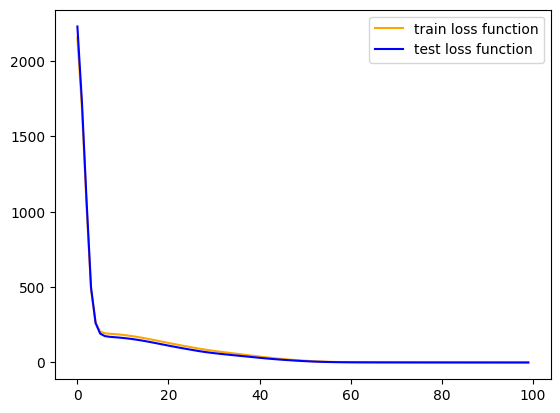

In [ ]:
plt.figure()
plt.plot(steps,train_loss_function,c='orange',label = "train loss function")
plt.plot(steps,test_loss_function,c='blue',label = "test loss function")
plt.legend()
plt.show()

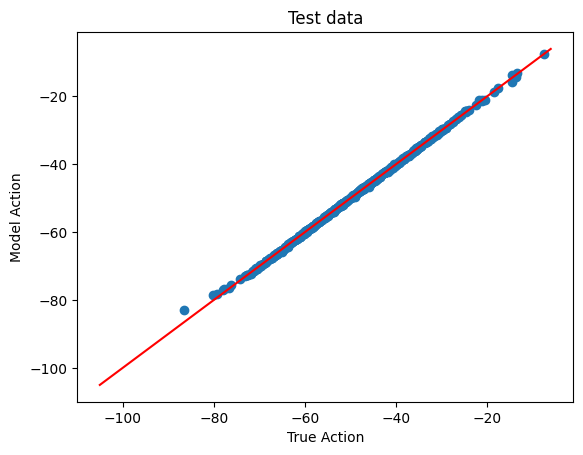

In [ ]:
def linear_function(x):
  return x

real_action = y_test.numpy()
model_action = test_pred.numpy()
x = [i-105 for i in range(100)]

plt.figure()
plt.title('Test data')
plt.plot(x,linear_function(x),c='r')
plt.scatter(real_action,model_action)
plt.plot()
plt.xlabel("True Action")
plt.ylabel("Model Action")

plt.show()

In [ ]:
def nn_model_action(phi,model):
      new_tensor = torch.tensor(phi.flatten()).to(torch.float32)
      value = model(new_tensor).detach().numpy()[0]

      return value

# Testing the total action Metropolis Hastings

In [ ]:
def hybrid_monte_carlo2(phi,L,mu,lmd,model):
  A = 0
  for i, j,delta in zip(np.random.randint(0,L,size=L*L), np.random.randint(0,L, size=L*L), np.random.normal(0,1,size=L*L)):

    S_old_nn = nn_model_action(phi,model)
    S_old_true = action2(phi,L,mu,lmd)
    phi[i,j] = phi[i,j] + 0.1*delta

    S_new_nn = nn_model_action(phi,model)
    S_new_true = action2(phi,L,mu,lmd)

    dS_true= S_new_true - S_old_true
    dS_nn = S_new_nn - S_old_nn

    p = min(1, np.exp(-dS_true))
    if(np.random.rand()<p):
      A += 1
    else:
      phi[i,j] = phi[i,j] - delta

  return dS_nn, dS_true, S_new_true, S_new_nn, S_old_nn, S_old_true

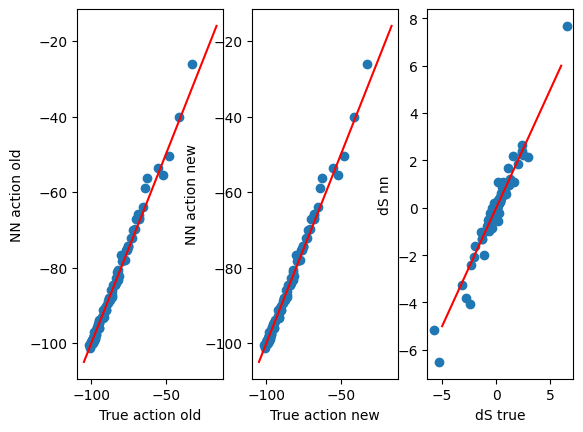

In [ ]:
L = 2
mu = 1
lmd = 0.1
steps = 100
lattice = np.random.normal(0,1,(L,L))
S_true_o = []
S_nn_o = []
phis = []
dS_true = []
dS_nn = []
S_true_n = []
S_nn_n = []
x = [i-105 for i in range(90)]
def linear_function(x):
  return x

for i in range(1000):
  hybrid_monte_carlo2(lattice,L,mu,lmd,model)
for j in range(steps):
  a, b, c, d, k, l = hybrid_monte_carlo2(lattice,L,mu,lmd,model)
  S_true_o.append(l)
  S_nn_o.append(k)
  dS_true.append(b)
  dS_nn.append(a)
  S_true_n.append(c)
  S_nn_n.append(d)
  phis.append(lattice.flatten())
  #print(f"the dS nn is {a} and the dS true is {b}")
  #print("---------------------------------------")
  #print(f"the Snew nn is {d} and the Snew true is {c} ")
  #print("---------------------------------------")
  #print(f"the Sold nn is {k} and the Sold true is {l}")
  #print("---------------------------------------")
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.plot(x,linear_function(x),c='r')
ax1.scatter(S_true_o,S_nn_o)
ax1.set(xlabel = "True action old", ylabel = "NN action old")


ax2.plot(x,linear_function(x),c='r')
ax2.scatter(S_true_o,S_nn_o)
ax2.set(xlabel = "True action new", ylabel = "NN action new")

dx = [i-5 for i in range(12)]

ax3.plot(dx,linear_function(dx),c='r')
ax3.scatter(dS_true,dS_nn)
ax3.set(xlabel = "dS true", ylabel = "dS nn")
plt.show()

3.9214611256990075


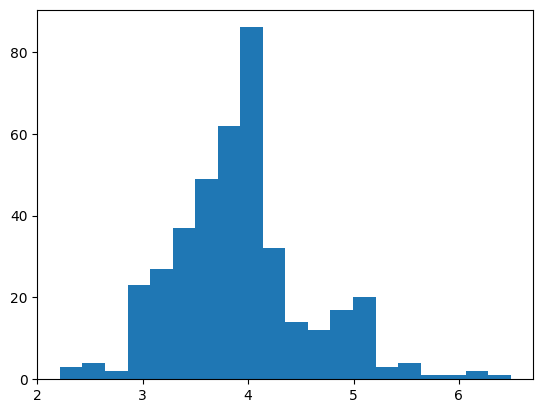

In [ ]:
plt.figure()
flattened_list_samples = [item for sublist in phis for item in sublist]
num_bins = int(np.sqrt(len(flattened_list_samples)))
plt.hist(flattened_list_samples, bins=num_bins)
print(np.mean(np.array(flattened_list_samples)))
plt.show()

# Testing the local Metropolis hastings algorithm

In [ ]:
def hybrid_monte_carlo(phi,L,mu,lmd,model):
  A = 0
  for i, j,delta in zip(np.random.randint(0,L,size=L*L), np.random.randint(0,L, size=L*L), np.random.normal(0,1,size=L*L)):

    #W_old = -mu*phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + phi[i,j]**2 +lmd * (phi[i,j]**2 -1)**2
    W_old =  -phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + (2+mu/2)*phi[i,j]**2 +lmd/(4*3*2) * phi[i,j]**4

    S_old_nn = nn_model_action(phi,model)
    S_old_true = action(phi,L,mu,lmd)
    phi[i,j] = phi[i,j] + delta

    #W_new = -mu*phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + phi[i,j]**2 +lmd * (phi[i,j]**2 -1)**2
    W_new =  -phi[i,j]*(phi[(i+1)%L,j]+phi[(i-1)%L,j]+phi[i, (j+1)%L]+phi[i, (j-1)%L]) + (2+mu/2)*phi[i,j]**2 +lmd/(4*3*2) * phi[i,j]**4

    S_new_nn = nn_model_action(phi,model)
    S_new_true = action(phi,L,mu,lmd)

    dS_true= S_new_true - S_old_true
    dS_nn = S_new_nn - S_old_nn
    dW = W_new -  W_old
    p = min(1, np.exp(-dW))
    if(np.random.rand()<p):
      A += 1
    else:
      phi[i,j] = phi[i,j] - delta

  return dS_nn, dS_true, S_new_true, S_new_nn, S_old_nn, S_old_true, dW, W_old, W_new

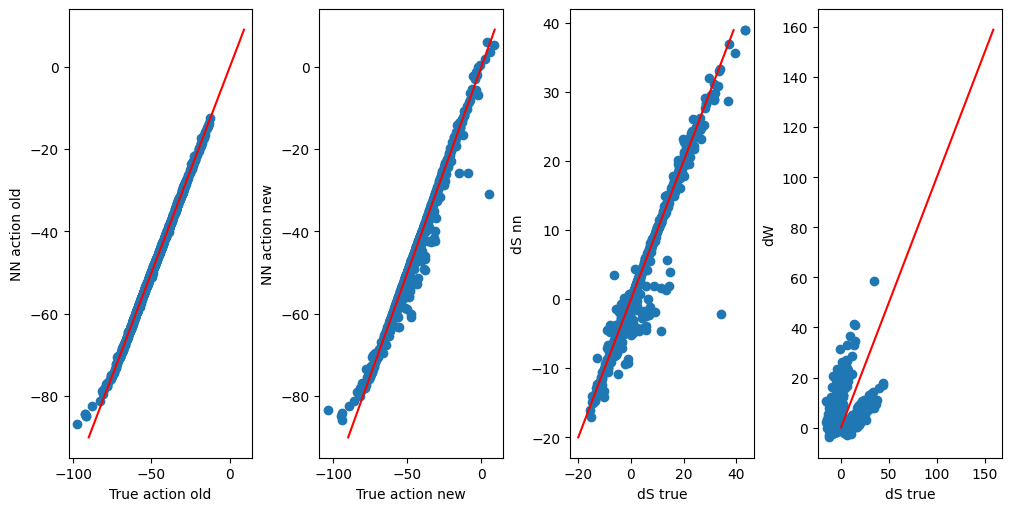

In [ ]:
L = 2
mu = -1
lmd = 1
steps = 1000
lattice = np.random.normal(0,1,(L,L))
S_true_old = []
S_nn_old = []
S_true_new = []
S_nn_new = []
dS_nn = []
dS_true = []
dW = []
phis = []
for i in range(100):
  hybrid_monte_carlo(lattice,L,mu,lmd,model)
for j in range(steps):
  a, b, c, d, k, l, x,y,z = hybrid_monte_carlo(lattice,L,mu,lmd,model)
  S_true_old.append(l)
  S_nn_old.append(k)
  S_true_new.append(c)
  S_nn_new.append(d)
  dS_nn.append(a)
  dS_true.append(b)
  dW.append(x)

  phis.append(lattice.flatten())
  #print(f"the dS nn is {a} and the dS true is {b} and the dW {x}")
  #print("---------------------------------------")
  #print(f"the Snew nn is {d} and the Snew true is {c} and the W_old {y} ")
  #print("---------------------------------------")
  #print(f"the Sold nn is {k} and the Sold true is {l} and the W_new{z}")
  #print("---------------------------------------")

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize = (10,5),constrained_layout = True)

x = [i-90 for i in range(100)]
ax1.plot(x,linear_function(x),c='r')
ax1.scatter(S_true_old,S_nn_old)
ax1.set(xlabel = "True action old", ylabel = "NN action old")


ax2.plot(x,linear_function(x),c='r')
ax2.scatter(S_true_new,S_nn_new)
ax2.set(xlabel = "True action new", ylabel = "NN action new")

dx = [i-20 for i in range(60)]

ax3.plot(dx,linear_function(dx),c='r')
ax3.scatter(dS_true,dS_nn)
ax3.set(xlabel = "dS true", ylabel = "dS nn")

dxk = [i for i in range(160)]
ax4.plot(dxk,linear_function(dxk),c='r')
ax4.scatter(dS_true,dW)
ax4.set(xlabel = "dS true", ylabel = "dW")

plt.show()

-2.1565840799979505


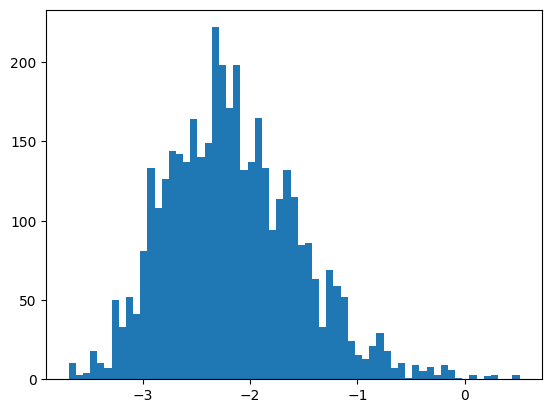

In [ ]:
plt.figure()
flattened_list_samples = [item for sublist in phis for item in sublist]
num_bins = int(np.sqrt(len(flattened_list_samples)))
plt.hist(flattened_list_samples, bins=num_bins)
print(np.mean(np.array(flattened_list_samples)))
plt.show()